In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, 
import xgboost as xgb
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import VotingClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

/var/folders/h6/klqm942163g8_92mq9zfhszm0000gn/T/ipykernel_9069/2915845131.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# It makes sense to drop track_id artist_name and title

# TODO
# - Normalization/Standardization of most if not all of these features
# - Figure out what do do with time_signature, key and mode
# - Pop and Classic rock have 15,000 entries while Rap/Hip hop only has 500 or so, we will either need to downsample
#   or else make use of synthetic minority oversampling
# - Note that loudness has some negative values. This may affect our approach for normalization. We may also need to keep in mind that
#   this is probably measured in decibels and is thus logarithmic. 
#   I believe this won't be a problem as the network can learn non linear relationships

# - I will try twice. One dropping the key attribute, one time with it. On a purely musical level the key doesn't mattert
#   but it's possible that certain genres use one key more often, and it's possible that the timbre measurements could have some synergy
#   with the key in play.

smote = SMOTE()

df = pd.read_csv('msd_genre_dataset.txt')
df_relevant_features = df.drop(columns=["track_id", "artist_name", "title"])
df_relevant_features.head()

X_resampled, y_resampled = smote.fit_resample(df_relevant_features.drop(columns=['genre']), df_relevant_features['genre'])

# X = df_relevant_features.drop(columns=['key'])

#X = pd.get_dummies(X, columns=['time_signature', 'key', 'mode'])
X = pd.get_dummies(X_resampled, columns=['time_signature', 'mode'])

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_resampled)
genre_classes = list(label_encoder.classes_)


# Now the data is properly encoded and irrelevant variables are gone

# Normalize the features

scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Convert normalized features back to a DataFrame for easier inspection
X_normalized_df = pd.DataFrame(X_normalized, columns=X.columns)





Iteration 1, loss = 1.25326591
Iteration 2, loss = 1.04578388
Iteration 3, loss = 0.98309716
Iteration 4, loss = 0.94254635
Iteration 5, loss = 0.91223128
Iteration 6, loss = 0.88968813
Iteration 7, loss = 0.87207665
Iteration 8, loss = 0.85658597
Iteration 9, loss = 0.84368908
Iteration 10, loss = 0.83242846
Iteration 11, loss = 0.82358666
Iteration 12, loss = 0.81449393
Iteration 13, loss = 0.80678646
Iteration 14, loss = 0.80014820
Iteration 15, loss = 0.79356651
Iteration 16, loss = 0.78629966
Iteration 17, loss = 0.78057330
Iteration 18, loss = 0.77583778
Iteration 19, loss = 0.77106938
Iteration 20, loss = 0.76669605
Iteration 21, loss = 0.76200727
Iteration 22, loss = 0.75754176
Iteration 23, loss = 0.75395912
Iteration 24, loss = 0.75035868
Iteration 25, loss = 0.74672739
Iteration 26, loss = 0.74380302
Iteration 27, loss = 0.74081041
Iteration 28, loss = 0.73723985
Iteration 29, loss = 0.73423831
Iteration 30, loss = 0.73196356
Iteration 31, loss = 0.72830583
Iteration 32, los

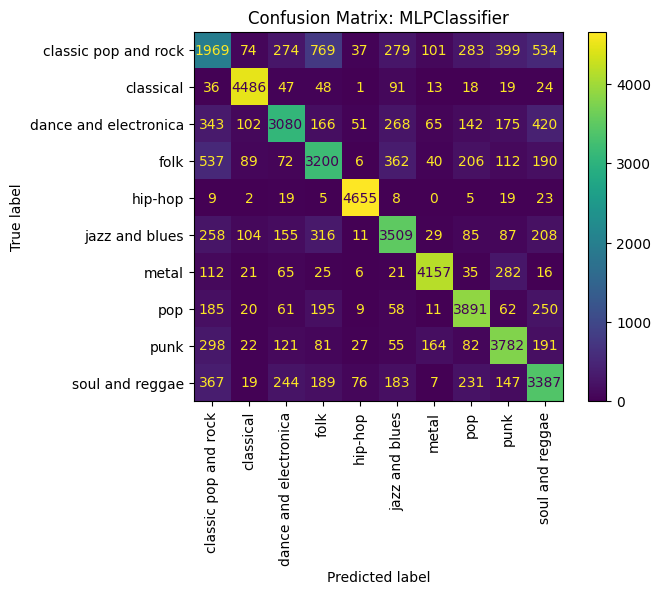

----- RandomForestClassifier -----
Accuracy: 0.8802
F1 Score: 0.8755


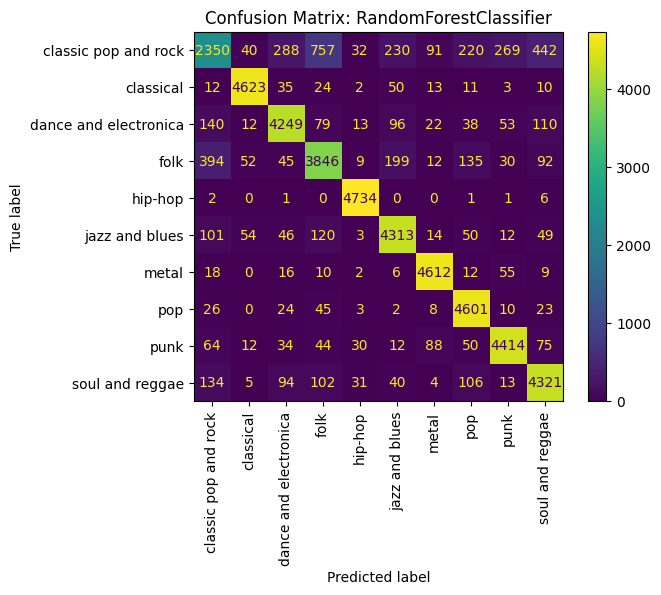

----- XGBClassifier -----
Accuracy: 0.7900
F1 Score: 0.7877


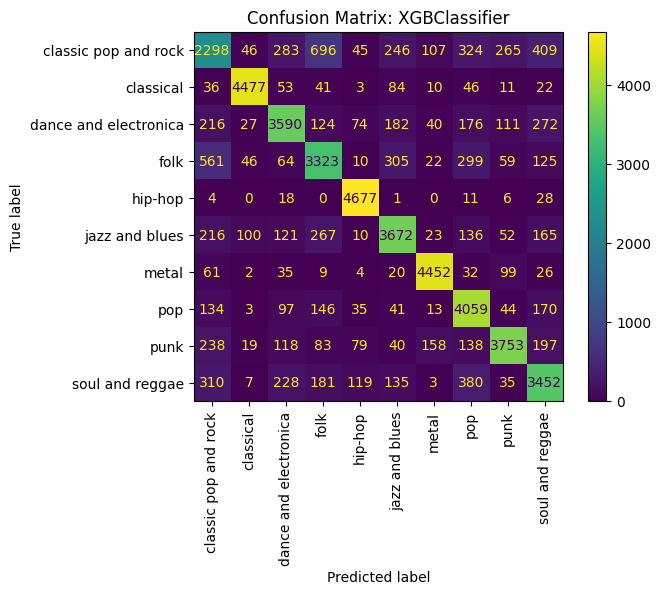

----- KNeighborsClassifier -----
Accuracy: 0.8499
F1 Score: 0.8351


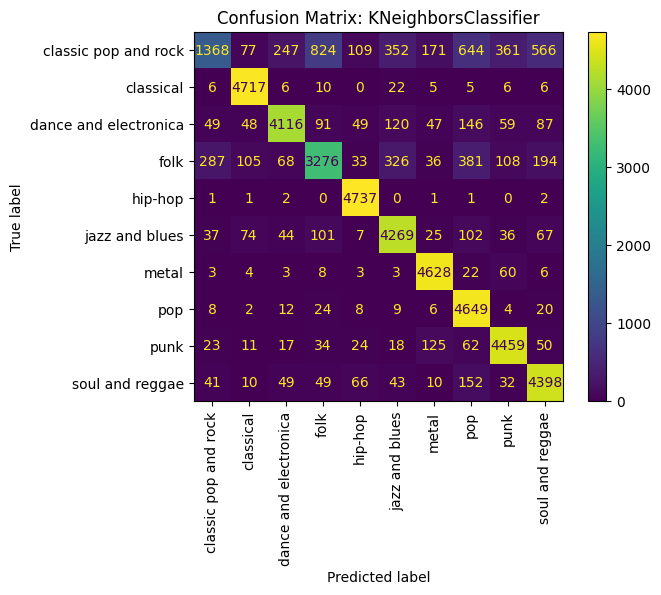

In [4]:
### Intermodel comparision ###

from sklearn.metrics import ConfusionMatrixDisplay, f1_score, confusion_matrix
import matplotlib.pyplot as plt


X_train, X_test, y_train, y_test = train_test_split(X_normalized_df, y, test_size=0.2, random_state=None)

models = {
    "MLPClassifier": MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, max_iter=300, shuffle=True, random_state=42, verbose=True),
    "RandomForestClassifier": RandomForestClassifier(),
    "XGBClassifier": xgb.XGBClassifier(),
    "KNeighborsClassifier": KNeighborsClassifier(n_neighbors=4, weights="distance"),
}

# Adding the ensemble model
ensemble_clf = VotingClassifier(estimators=[
    ('mlp', models['MLPClassifier']),
    ('rf', models['RandomForestClassifier']),
    ('xgb', models['XGBClassifier']),
    ('knn', models['KNeighborsClassifier'])
], voting='soft', weights=[1, 2, 1, 1])

models["Ensemble"] = ensemble_clf

# Evaluating each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_test, y_pred)

    print(f"----- {name} -----")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    # Display confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder.classes_)
    disp.plot()
    plt.xticks(rotation=90)
    plt.title(f"Confusion Matrix: {name}")
    plt.show()

In [6]:
ensemble_clf = VotingClassifier(estimators=[
    ('mlp', models['MLPClassifier']),
    ('rf', models['RandomForestClassifier']),
    ('xgb', models['XGBClassifier']),
    ('knn', models['KNeighborsClassifier'])
], voting='soft', weights=[1, 2, 1, 1])
ensemble_clf.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"----- {name} -----")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder.classes_)
disp.plot()
plt.xticks(rotation=90)
plt.title(f"Confusion Matrix: {name}")
plt.show()

Iteration 1, loss = 1.25326591
Iteration 2, loss = 1.04578388
Iteration 3, loss = 0.98309716
Iteration 4, loss = 0.94254635
Iteration 5, loss = 0.91223128
Iteration 6, loss = 0.88968813
Iteration 7, loss = 0.87207665
Iteration 8, loss = 0.85658597
Iteration 9, loss = 0.84368908


/usr/local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [5]:
### Takeaways ###

# With a PCA of ten PCs, and an MLP with 100 and 50 layers, we got 50% test accuracy
# W/o PCA we got nearly 60%
# I bet the low accuracy has something to do with the skewed data, that's probably our next step!